#

## Задание

На основе рассмотренного на лекции примера реализуйте следующие алгоритмы:

-   SARSA
-   Q-обучение
-   Двойное Q-обучение

для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

## Выполнение

Исходный код программы:

``` python
import sys

import gym

from toy_environment.consts import CLIFF_WALKING_ENV

from time_difference_algorithms.basic_agent import BasicAgent
from time_difference_algorithms.sarsa_agent import SarsaAgent
from time_difference_algorithms.q_learning_agent import QLearningAgent
from time_difference_algorithms.double_q_learning_agent import DoubleQLearningAgent

ENV = CLIFF_WALKING_ENV


def play_agent(agent):
    """
    Проигрывание сессии для обученного агента
    """
    env = gym.make(ENV["name"], render_mode="human")
    state = env.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        env.render()
        state = next_state
        if terminated or truncated:
            done = True


def run_algorithm(agent: BasicAgent):
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)


def run_sarsa():
    env = gym.make(ENV["name"])
    agent = SarsaAgent(env)

    run_algorithm(agent)


def run_q_learning():
    env = gym.make(ENV["name"])
    agent = QLearningAgent(env)

    run_algorithm(agent)


def run_double_q_learning():
    env = gym.make(ENV["name"])
    agent = DoubleQLearningAgent(env)

    run_algorithm(agent)


def main(algorithm: str):
    match algorithm:
        case "sarsa":
            run_sarsa()
        case "q_learning":
            run_q_learning()
        case "double_q_learning":
            run_double_q_learning()
        case _:
            print("Choose algorithm from one of the existing")


if __name__ == "__main__":
    print(sys.argv)

    if len(sys.argv) < 2:
        raise Exception('Please choose algorithm by passing argument')

    main(algorithm=sys.argv[1])
```

В главном модуле используются агенты, отдельно реализованные для каждого алгоритма.

### Basic Agent

Используется для создания других агентов.

``` python
import numpy as np
import matplotlib.pyplot as plt


class BasicAgent:
    """
    Базовый агент, от которого наследуются стратегии обучения
    """

    # Наименование алгоритма
    ALGO_NAME = "---"

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        # и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps = eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print("Вывод Q-матрицы для алгоритма ", self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        """
        Возвращает правильное начальное состояние
        """
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    def greedy(self, state):
        """
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        """
        return np.argmax(self.Q[state])

    def make_action(self, state):
        """
        Выбор действия агентом
        """
        if np.random.uniform(0, 1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize=(15, 10))
        y = self.episodes_reward
        x = list(range(1, len(y) + 1))
        plt.plot(x, y, "-", linewidth=1, color="green")
        plt.title("Награды по эпизодам")
        plt.xlabel("Номер эпизода")
        plt.ylabel("Награда")
        plt.show()

    def learn(self):
        """
        Реализация алгоритма обучения
        """
        pass
```

### Sarsa Agent

``` python
from tqdm import tqdm

from time_difference_algorithms.basic_agent import BasicAgent


class SarsaAgent(BasicAgent):
    """
    Реализация алгоритма SARSA
    """

    # Наименование алгоритма
    ALGO_NAME = "SARSA"

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        """
        Обучение на основе алгоритма SARSA
        """
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * (
                    rew
                    + self.gamma * self.Q[next_state][next_action]
                    - self.Q[state][action]
                )

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)
```

### Q Learning Agent

``` python
from tqdm import tqdm
import numpy as np

from time_difference_algorithms.basic_agent import BasicAgent


class QLearningAgent(BasicAgent):
    """
    Реализация алгоритма Q-Learning
    """

    # Наименование алгоритма
    ALGO_NAME = "Q-обучение"

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        """
        Обучение на основе алгоритма Q-Learning
        """
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * (
                    rew
                    + self.gamma * np.max(self.Q[next_state])
                    - self.Q[state][action]
                )

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)
```

### Double Q Learning

``` python
from tqdm import tqdm
import numpy as np

from time_difference_algorithms.basic_agent import BasicAgent


class DoubleQLearningAgent(BasicAgent):
    """
    Реализация алгоритма Double Q-Learning
    """

    # Наименование алгоритма
    ALGO_NAME = "Двойное Q-обучение"

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def greedy(self, state):
        """
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        """
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print("Вывод Q-матриц для алгоритма ", self.ALGO_NAME)
        print("Q1")
        print(self.Q)
        print("Q2")
        print(self.Q2)

    def learn(self):
        """
        Обучение на основе алгоритма Double Q-Learning
        """
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * (
                        rew
                        + self.gamma
                        * self.Q2[next_state][np.argmax(self.Q[next_state])]
                        - self.Q[state][action]
                    )
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * (
                        rew
                        + self.gamma
                        * self.Q[next_state][np.argmax(self.Q2[next_state])]
                        - self.Q2[state][action]
                    )

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)
```

### Результат

Агент выбирается из аргументов консольной строки.

-   Sarsa Agent 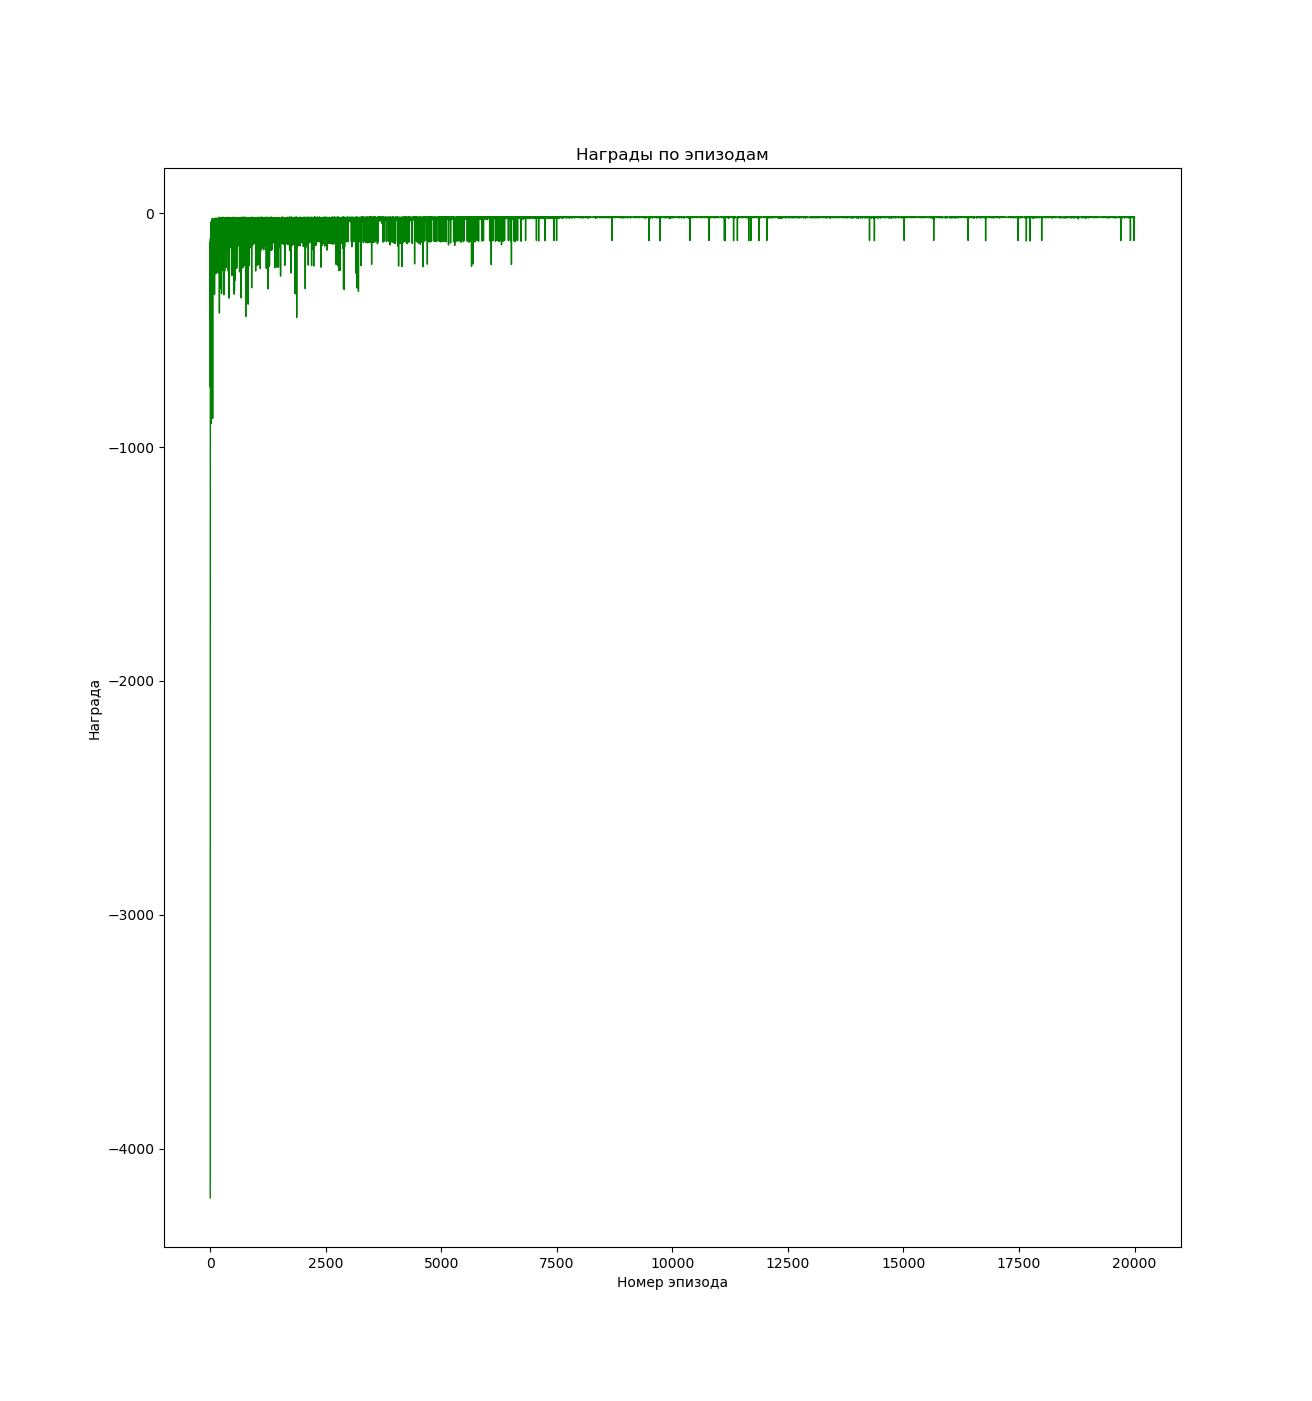 
-   Q Learning Agent 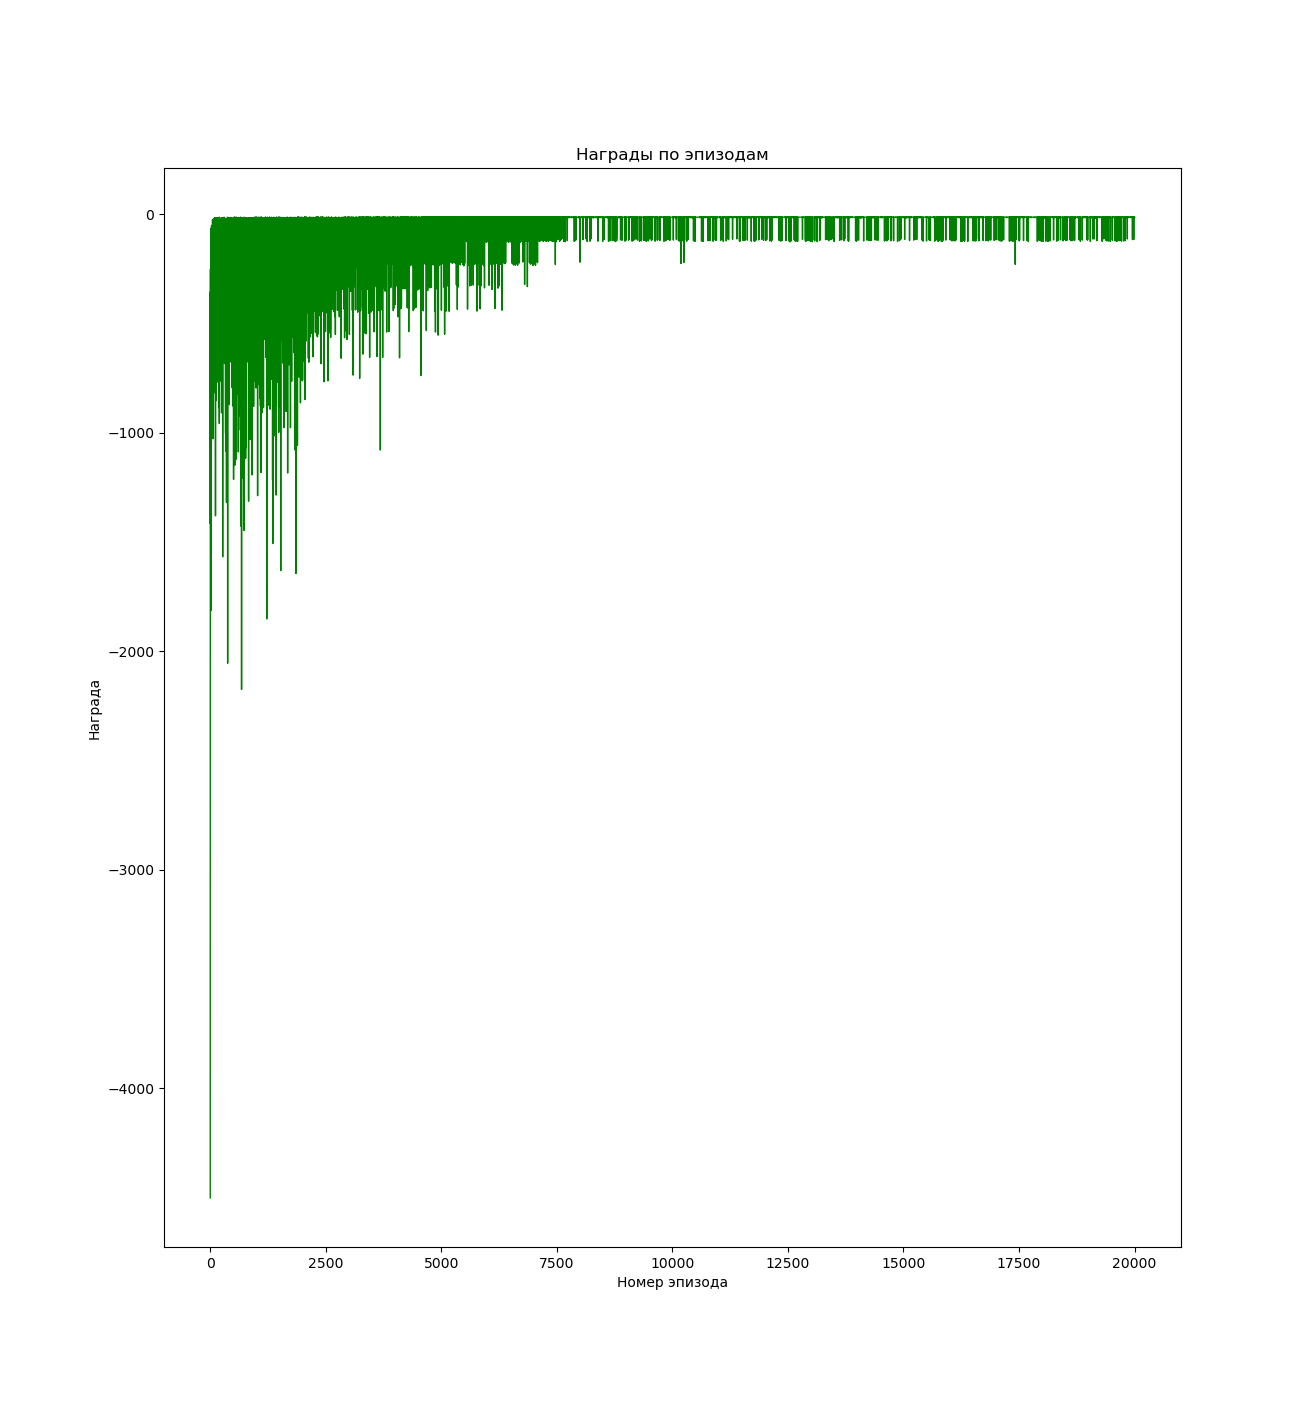 
-   Double Q Learning Agent 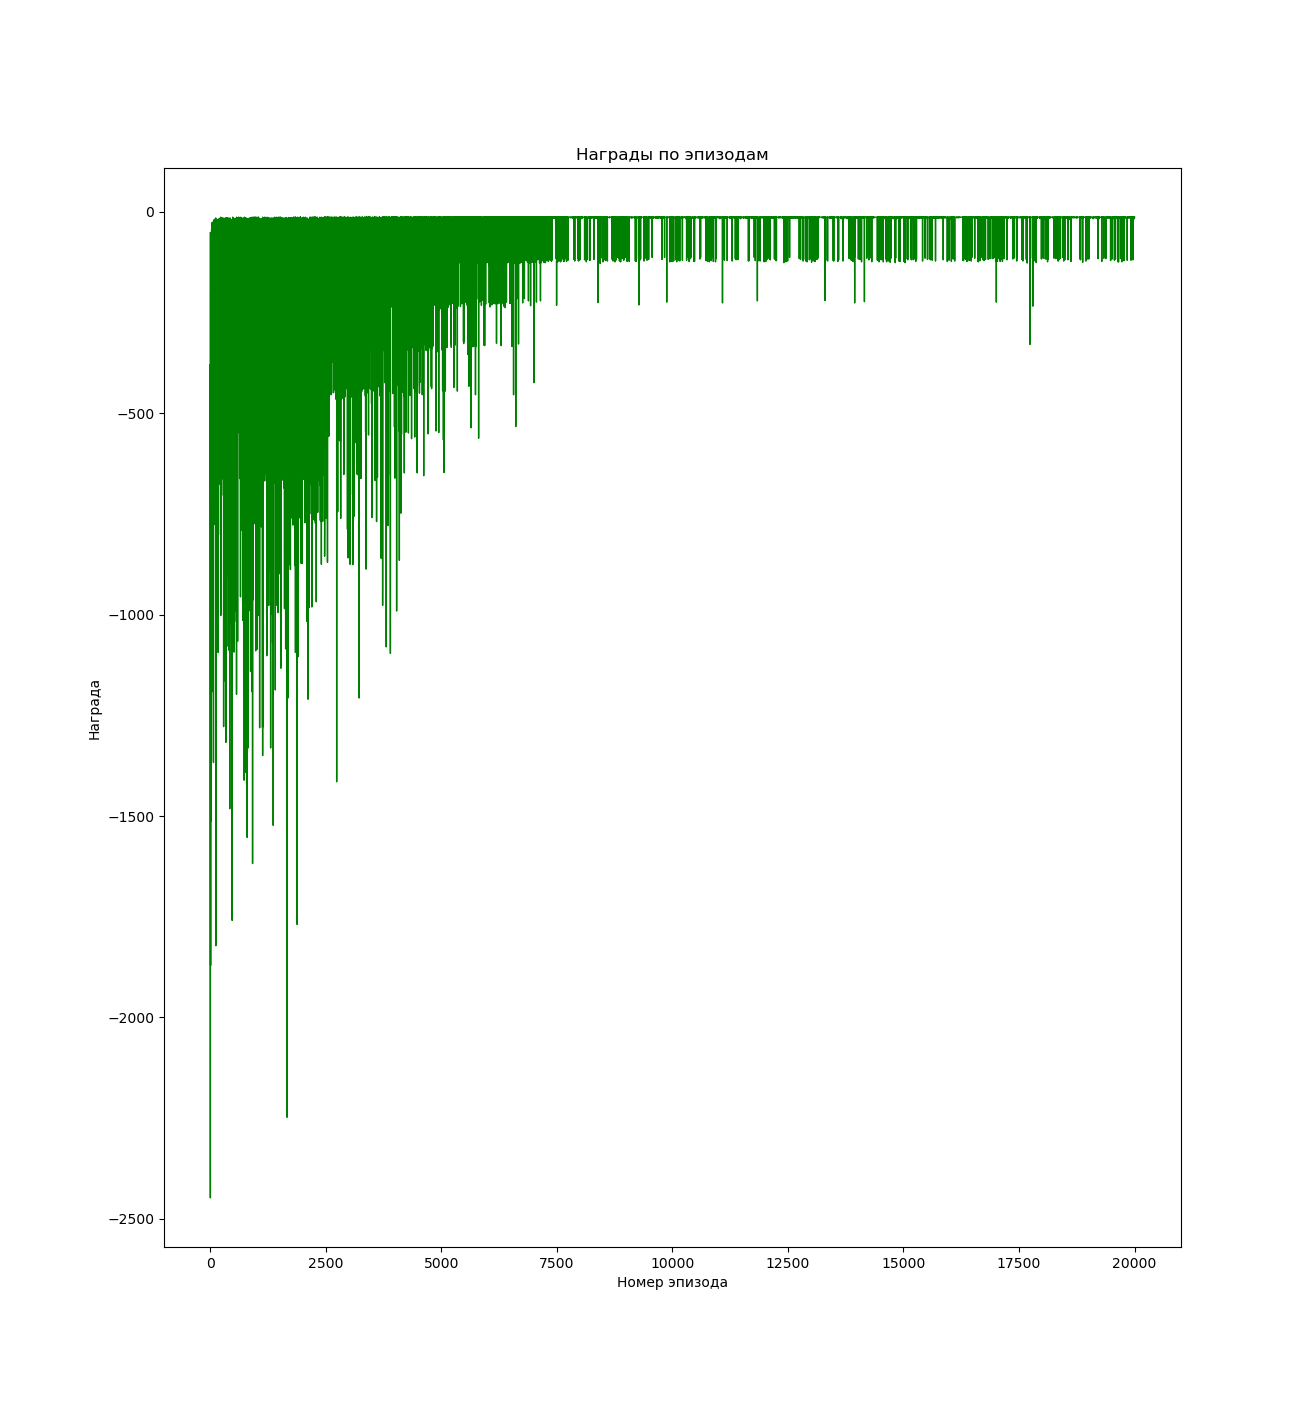 

## Вывод

Все три алгоритма отлично справились с поставленной задачей. Однако QLearning и DoubleQLearning решили её эффективнее: агент обходит пропасть по самому краю обрыва, тратя меньше ходов, чем агент, обучающийся по алгоритму Sarsa.